# Appling machine learning to audio analysis

## Code for Predicting with moving window

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2022-01-23 13:04:16.957277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-23 13:04:16.957340: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# To play audio file:
import IPython.display as ipd

In [ ]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

## MFCCs - Mel-Frequency Cepstrum Coefficients

### Functions to extract the MFCCs from every file in our dataset

In [60]:
# funçao com gerador que guarda os valores da atual posição da janela e calcula os proximos
def windows(audio, window_size):
    start = 0
    while start < len(audio):
        yield start, start + window_size # a função para aqui e returna o valor para a outra função
        start += (window_size // 10) #calcula a posição inicial do proximo segmento
        

In [67]:
def extract_features(file_name, window_size):
    #upload do audio
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    
    #list de retorno
    mfccsArr = []
    
    # A função gerador é um iteravel a partir dos valores gerados durante a keyword yield
    #Percorre um audio inteiro
    for (start,end) in windows(audio, window_size):
        #Enquanto a janela nao atingir o fim do audio
        if end <= len(audio): 
            #entao define um excerto do audio
            signal = audio[start:end]
            # e calcula os coeficientes de mel
            mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
            mfccs_processed = np.mean(mfccs.T,axis=0)
            mfccsArr.append([mfccs_processed])
    # Retorna os coeficientes de mel em forma de lista do audio inteiro
    return mfccsArr

### Code to save the MFCCs

In [68]:
features = []# Iterate through each sound file and extract the features 

df = pd.read_csv('../csvFiles/set_a - Copia.csv')

windowSize = 3000

In [69]:
for index, row in df.iterrows():
    
    absolutePath = os.path.abspath("../")
    fname = str(row["fname"])
    print(fname)
    file_name = os.path.join(absolutePath,fname)
 
    data = extract_features(file_name, windowSize)
    
    for item in data:
        features.append(item)
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature'])

set_a/normal__201108011114.wav


In [70]:
featuresdf.head()

,feature
0,"[-619.4802, 164.81221, 61.611187, 27.008148, 3..."
1,"[-677.06586, 214.36499, 58.828716, 11.51953, 4..."
2,"[-663.1361, 201.0767, 62.281616, 17.150503, 40..."
3,"[-656.9102, 200.3762, 63.165554, 17.528437, 39..."
4,"[-657.5186, 198.93721, 61.94527, 17.597023, 39..."


In [65]:
featuresdf.iloc[0]['feature']
fileMFCCs = '../MFCCs/' + fname + "_" + str(windowSize) + '.pkl'
featuresdf.to_pickle(fileMFCCs) 

### Plot of MFCCs

#### Complete audio file

[[-5.1027075e+02 -5.1784747e+02 -5.1645111e+02 ... -5.1235010e+02
  -5.0315436e+02 -5.0393527e+02]
 [ 7.6559082e+01  7.3185158e+01  7.5095856e+01 ...  8.0131142e+01
   8.9822380e+01  8.8335327e+01]
 [ 5.7282753e+01  6.0728516e+01  6.2406868e+01 ...  6.5456512e+01
   6.8181351e+01  6.5443047e+01]
 ...
 [ 2.4334965e+00  1.5996500e+00 -6.1852312e-01 ... -1.8013918e+00
   3.0388794e+00  4.9856334e+00]
 [ 1.2857683e+00  1.3779308e+00 -3.4722933e-01 ... -1.9498968e+00
   3.1488287e+00  5.3416424e+00]
 [ 3.0678864e+00  1.8521523e+00  7.7059972e-01 ... -1.9233688e+00
   1.8666532e+00  4.5611501e+00]]


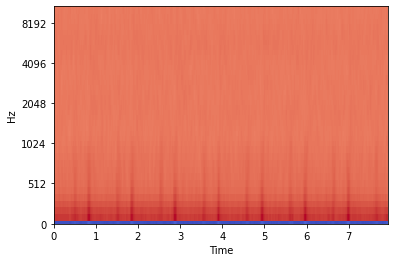

In [112]:
audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc = 40)
print(mfccs)
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', y_axis='mel')

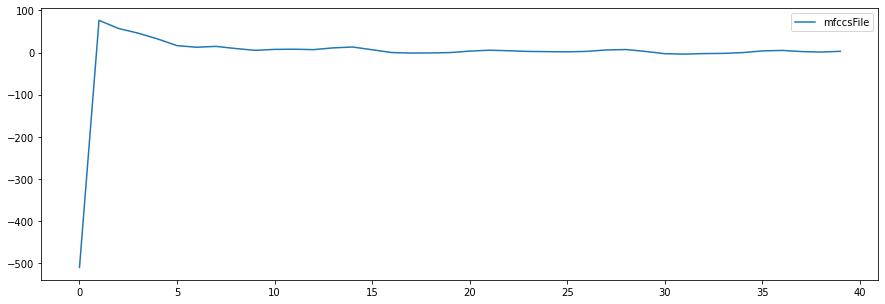

In [123]:
mfccsArr = np.array(featuresdf.feature.tolist())

plt.figure(figsize=(15,5))
plt.plot(mfccs[:,0], label='mfccsFile')
plt.legend()

#### Sampling windows

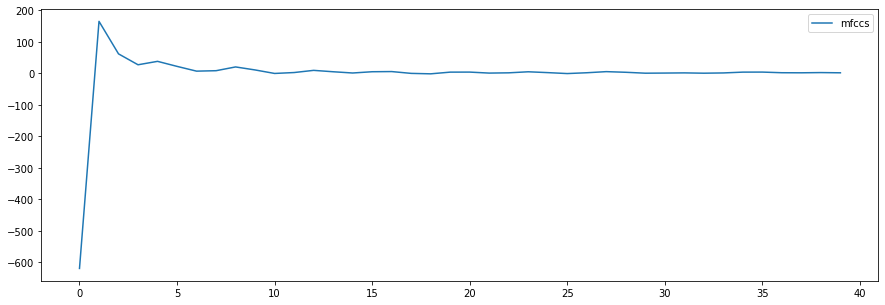

In [124]:
plt.figure(figsize=(15,5))
plt.plot(mfccsArr[0], label='mfccs')
plt.legend()

## Model's Predections

### Load Model from saved files

In [12]:
model = load_model('../model_save/cut_setA_700Epoch/saved_model', compile = True)

2022-01-23 13:04:34.427826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-23 13:04:34.431483: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-23 13:04:34.431554: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chico-VirtualBox): /proc/driver/nvidia/version does not exist
2022-01-23 13:04:34.432124: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
fileMFCCs = '../MFCCs/completeSetA_' + '3000' + '.pkl'
fileMFCCs = '../MFCCs/' + fname + "_" + str(windowSize) + '.pkl'
featuresdf = pd.read_pickle(fileMFCCs)
featuresdf.head()

,feature
0,"[-619.4802, 164.81221, 61.611187, 27.008148, 3..."
1,"[-677.06586, 214.36499, 58.828716, 11.51953, 4..."
2,"[-663.1361, 201.0767, 62.281616, 17.150503, 40..."
3,"[-656.9102, 200.3762, 63.165554, 17.528437, 39..."
4,"[-657.5186, 198.93721, 61.94527, 17.597023, 39..."


### Predections (SOFTMAX func)

In [126]:
X = np.array(featuresdf.feature.tolist())
predictions = model.predict(X)

### Obtaining the time domain from samples domain

In [29]:
timeDomain = []

SR = 22050
initT = 1500
for i in predictions:
    sec = initT/SR
    timeDomain.append(sec)
    initT += 300

### Finding predictions that are over 50%

In [35]:
#Array containing predictions over 50%
beatPositions = np.array([0,0,0])
#the mininum value to identify a signal as S1 or S2
treshold = 0.45

#iterate over the matrix of predictions
for index in range(np.size(predictions,0)):
    #get line vectors and the repective prediction for S1 and S2
    a = predictions[index][0]
    b = predictions[index][1]
    c = predictions[index][2]
    
    #if the prediction for S1 is over the treshold value
    if(a > treshold and b < treshold):
        #then the index and the prediction is added to the vector beatPositions
        vector = np.array([index, a, 0])
        beatPositions = np.vstack((beatPositions, vector))
    #Similar to above
    elif (b > treshold and a < treshold):
        vector = np.array([index, 0, b])
        beatPositions = np.vstack((beatPositions, vector))
    #When need this because the next algorithm depends on separation of intervals using 0 values
    elif (c > treshold):
        vector = np.array([index, 0, 0])
        beatPositions = np.vstack((beatPositions, vector))
        
        
#beatPositions = np.vstack((beatPositions, np.array([0,0,0])))

### Finding the max predictions within a given interval of values above the threshold

In [31]:
def maxS(arrIn, arrOut, sound):
    #Vector to save values to compare with the following indexed itens
    maxArr = np.array([0, 0])
    #iterate over the predictions over the threshold
    for item in arrIn:
        #if current prediction is bigger than the one saved in maxArr
        if (item[sound] > maxArr[1]):
            #then change it 
            maxArr = np.array([item[0], item[sound]])
        #if current prediction is zero and the stored prediction is not zero
        if(item[sound] == 0 and maxArr[1] != 0):
            arrOut = np.vstack((arrOut, maxArr))
            maxArr = np.array([0,0])
            
       # if(item[sound] > treshold and (item[0] - maxArr[0]) > 8):
            #maxArr = np.array([item[0], item[sound]])

    
    return arrOut

### Arrays with max values of S1 and S2

In [33]:
maxSoneArr = np.array([0,0])
maxStwoArr = np.array([0,0])

maxSoneArr = maxS(beatPositions, maxSoneArr, 1)
maxStwoArr = maxS(beatPositions, maxStwoArr, 2)

### Hearbeat rate calculation

In [118]:
def heartBeat(inVec, timeD, sType):
    # The estimator is the unweighted mean
    i = 1
    deviation = 0
    while i < (np.size(inVec,0) - 1):
        #calculate the distance between consecutive maximums 
        # the inVec cotains the index of the sampling windows in predictions vector with max probability
        # timeD is a one to one transofrmation from sampling windows to time in seconds
        deviation += abs(timeD[int(inVec[i][0])] - timeD[int(inVec[i + 1][0])])
        i += 1
    
    hB = 1/(deviation/(np.size(inVec,0) - 2))
    
    return "Batimentos: " + str(round(hB,2)) + "Hz ou " + str(round(hB*60,2)) + " batimentos por minuto. \nCalculado com " + sType + "."

In [119]:
print(heartBeat(maxSoneArr, timeDomain, "S1"))
print(heartBeat(maxStwoArr, timeDomain, "S2"))

Batimentos: 2.93Hz ou 175.73 batimentos por minuto. 
Calculado com S1.
Batimentos: 0.97Hz ou 58.28 batimentos por minuto. 
Calculado com S2.


## Plot of Predictions

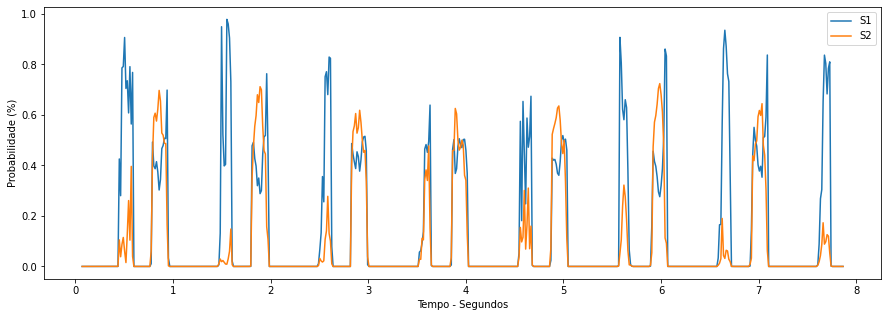

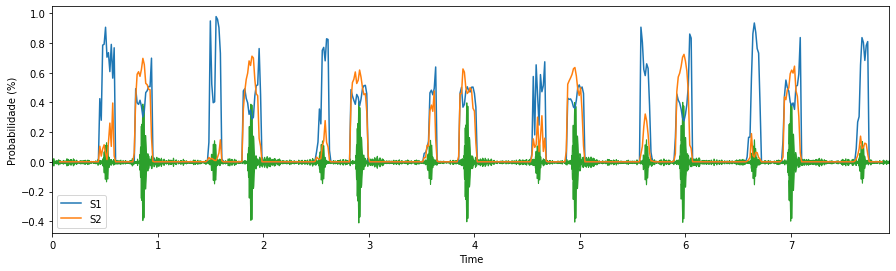

In [59]:
#Predictions relative to time
plt.figure(figsize=(15,5))
plt.plot(timeDomain, predictions[:,0], label='S1')
plt.plot(timeDomain, predictions[:,1], label='S2')
plt.xlabel("Tempo - Segundos")
plt.ylabel("Probabilidade (%)")
#plt.scatter(maxSoneArr[:,0], maxSoneArr[:,1], c='red')
#plt.scatter(maxStwoArr[:,0], maxStwoArr[:,1], c='black')
plt.legend()



#Plot predictions overlaping the signal in timeDomain
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

predicPlot = fig.add_subplot(2,1,1)
predicPlot.plot(timeDomain, predictions[:,0], label='S1')
predicPlot.plot(timeDomain, predictions[:,1], label='S2')
predicPlot.set_xlabel("Tempo - Segundos")
predicPlot.set_ylabel("Probabilidade (%)")
predicPlot.legend()

#Plot of the soundwave
name = '../set_a/normal__201108011114.wav'
data, sample_rate = librosa.load(name)
librosa.display.waveplot(data, sr = sample_rate)

## Moving average

### Summing function for moving average

In [ ]:
def movingAvg(inVec, index, interval, sType):
    avg = 0
    #starts a few steps behind
    i = -interval
    #Sums the predictions around the current one
    while (i < interval + 1):
        avg += inVec[index + i][sType]
        i += 1
        
    return (avg/(2*interval + 1))

In [ ]:
#Copy of the predictions vector
mvAvg = np.copy(predictions,"K")

#length to stop the for lop, can sum initial and final indexes
stopSize = np.size(predictions,0)
#lenght of the sum
sizeAvg = 1
#starting index
indexCount = sizeAvg
        
for item in predictions:
    if indexCount < stopSize - sizeAvg:
        
        mvAvg[indexCount][0] = movingAvg(predictions, indexCount, sizeAvg, 0)
        mvAvg[indexCount][1] = movingAvg(predictions, indexCount, sizeAvg, 1)
        
    indexCount += 1

### Plot

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(mvAvg[:,0], label='S1mv')
plt.plot(mvAvg[:,1], label='S2mv')
#plt.plot(predictions[:,0], label='S1')
#plt.plot(predictions[:,1], label='S2')
plt.xlim(-4, 574)
plt.legend()

## Integral average

In [ ]:
def integralAvg(inVec, dx, index, size, sType):
    avg = 0
    i = -size
    while i < size + 1:
        avg += dx*inVec[index + i][sType]
        i += 1
        
    return (avg/(2*size + 1))
    

In [ ]:
experiment.end()